### `Import the Main Libraries`

In [6]:
## Main Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import Image
import urllib

## sklearn -- Embeded Datasets
from sklearn import datasets

## sklearn -- Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

## sklearn -- metrics
from sklearn.metrics import silhouette_score

## sklearn -- Models
from sklearn.cluster import KMeans, DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

## scipy -- Models
from scipy.cluster.hierarchy import linkage, dendrogram     ## just for Hierarchical clustering
from scipy.stats import multivariate_normal

### `Create a Toy Dataset`

* > `it is preferable to standardize the data before clustering, I don't do here in this Notebook`

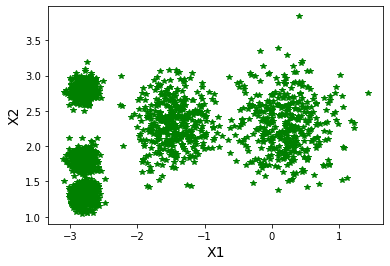

In [228]:
## make some datasets
blob_centers = np.array(
                    [[ 0.2,  2.3],
                     [-1.5,  2.3],
                     [-2.8,  1.8],
                     [-2.8,  2.8],
                     [-2.8,  1.3]])

blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1]) 

## using make_blobs
X, y = datasets.make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=42)


### Plotting
plt.figure(figsize=(6, 4))
plt.plot(X[:,0], X[:,1], 'g*')
plt.xlabel('X1', fontsize=14)
plt.ylabel('X2', fontsize=14)
plt.show()

### `Define K-Means`

y_pred => 
 [3 0 2 ... 0 3 1]
*********************************************
from _labels => 
 [3 0 2 ... 0 3 1]
*********************************************
centroids => 
 [[ 0.20925539  2.30351618]
 [-2.80372723  1.80873739]
 [-1.4453407   2.32051326]
 [-2.79846237  2.80004584]
 [-2.79244799  1.2973862 ]]
*********************************************


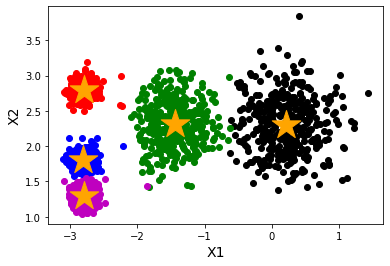

In [11]:
### Define KMeans

## n_clusters ---> define number of clusters let's start with 4 clusters
## n_init --->  number of initialization and clustering ,
## The algorithm make n_init=10 initalization of random centroids and get the inertia,
## And finally show the best one (lowest inertia)
## algorithm='auto' ---> to support accelerated Kmeans (it is prefeable (default)) 
## Accelerated Kmeans is avoiding many unnecessary distances calculations (full: the original version, elkan: refer to (Charles ELkan))
## init='k-means++' --->  this leads to kmeans++ (preferable and it is the default)

kmeans = KMeans(n_clusters=5, n_init=10, algorithm='auto', init='k-means++', random_state=42)

y_pred = kmeans.fit_predict(X)

print('y_pred => \n', y_pred)
print('***'*15)
print('from _labels => \n', kmeans.labels_)
print('***'*15)

cenroids = kmeans.cluster_centers_
print('centroids => \n', cenroids)
print('***'*15)

### Plotting
plt.figure(figsize=(6, 4))

plt.scatter(X[y_pred==0][:, 0], X[y_pred==0][:, 1], c='k')
plt.scatter(X[y_pred==1][:, 0], X[y_pred==1][:, 1], c='b')
plt.scatter(X[y_pred==2][:, 0], X[y_pred==2][:, 1], c='g')
plt.scatter(X[y_pred==3][:, 0], X[y_pred==3][:, 1], c='r')
plt.scatter(X[y_pred==4][:, 0], X[y_pred==4][:, 1], c='m')

plt.scatter(cenroids[:, 0], cenroids[:, 1], s=900, marker='*', c='orange')

plt.xlabel('X1', fontsize=14)
plt.ylabel('X2', fontsize=14)
plt.show()

In [12]:
## Inference
X_new = np.array([[0, 2],[3, 2],[-3, 3],[-3, 2.5]])  ## 4 new instances 
print('Prediction is \n', kmeans.predict(X_new))
print('****'*15)

## You can distance to each centroid --> here I have 4 instances with 5 centroids (4x5) each row for an instance
distances = kmeans.transform(X_new)
print('distances to each centroids => \n', distances)

Prediction is 
 [0 0 3 3]
************************************************************
distances to each centroids => 
 [[0.36865958 2.81024337 1.48045212 2.91057812 2.87948466]
 [2.80720102 5.80687792 4.45688037 5.85339553 5.8349053 ]
 [3.28396253 1.20732332 1.69666372 0.28389977 1.71521765]
 [3.21526454 0.7185868  1.56498595 0.36144837 1.22039247]]


In [13]:
## Check Inertia (score = - Inertia) -- sklearn always want to maximize the score function (minimize inertia)
print(f'Inertia ---> {kmeans.inertia_:.3f}')
print('**'*15)
print(f'Score ----> {kmeans.score(X):.3f}' )

Inertia ---> 213.422
******************************
Score ----> -213.422


### `Choose the best number of K`

#### `Elbow Method`

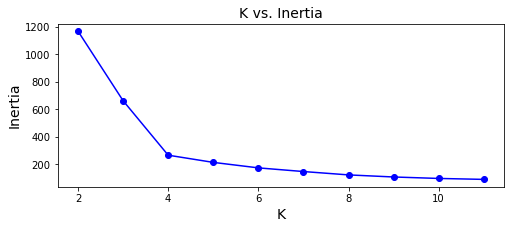

In [14]:
## Try different K and choose according to Elbow Method
k_choose = np.arange(2, 12, 1)  ## space we search in

k_with_inertia = {}

for val in k_choose:  ## loop over the space of K
    ## define the algorithm
    kmeans_each = KMeans(n_clusters=val, n_init=10, algorithm='auto', init='k-means++', random_state=42) 
    kmeans_each.fit(X) 
    each_inertia = kmeans_each.inertia_   ## get the best inertia for each K
    k_with_inertia[val] = each_inertia    ## to the dictionary
    
    
## Plotting each K with the opposite Inertia
plt.figure(figsize=(8, 3))
plt.plot(k_with_inertia.keys(), k_with_inertia.values(), 'bo-')
plt.title('K vs. Inertia', fontsize=14)
plt.xlabel('K', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.show()  ### using elbow method , here k=4 is the best , but let's use other metrics to see

#### `silhouette score`

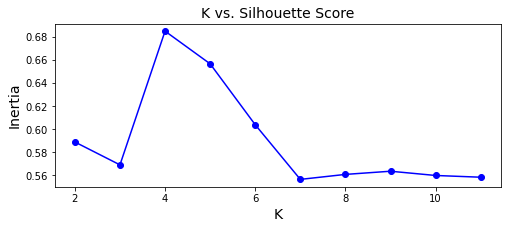

In [7]:
## try silhouette_score ranges (-1 -- 1)
k_with_score = {} 

for val in k_choose:  ## loop over the space of K
    ## define the algorithm
    kmeans_each = KMeans(n_clusters=val, n_init=10, algorithm='auto', init='k-means++', random_state=42) 
    kmeans_each.fit(X) 
    each_score = silhouette_score(X, kmeans_each.labels_)  ## get the score for each K
    k_with_score[val] = each_score    ## to the dictionary
    
    
## Plotting each K with the opposite Inertia
plt.figure(figsize=(8, 3))
plt.plot(k_with_score.keys(), k_with_score.values(), 'bo-')
plt.title('K vs. Silhouette Score', fontsize=14)
plt.xlabel('K', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.show()  ### using silhouette_score method , here k=4 is the best , but let's use other metrics to see

---

### `Using Clustering for Image Segmentation`

In [8]:
## Use Clustering for Images Segmentation
## Read image using (requests)
url = 'https://5.imimg.com/data5/SELLER/Default/2021/8/ED/TV/TX/2044246/sun-500x500.png'

## retrieve the image
urllib.request.urlretrieve(url, 'sample.png')
img = Image.open('sample.png')

Shape of Image -- (450, 500, 3)
Shape of reshaped Image -- (225000, 3)
# k=2 --- Done!
# k=4 --- Done!
# k=6 --- Done!
# k=8 --- Done!
# k=10 --- Done!
# k=12 --- Done!


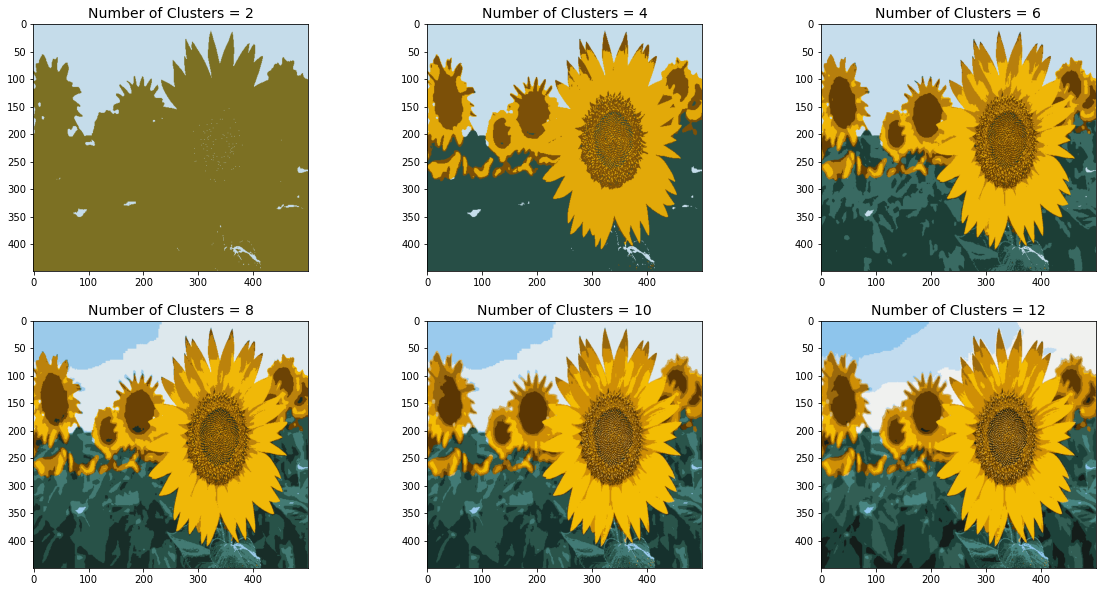

In [9]:
## To NumPy arary
img_array = np.array(img)
print('Shape of Image --', img_array.shape)

## Reshape the image to that each channel will be as a Feature 
## The image is (RGB) --- so I will have each channel values as a row 
## (450x500x3) ---> (225000, 3)
img_reshp = img_array.reshape(-1, 3)
print('Shape of reshaped Image --', img_reshp.shape)


## Define the KMeans
k_choose = np.arange(2, 14, 2)

y_pred_all = {}

for val in k_choose:  ## loop over the space of K
    ## define the algorithm
    kmeans_each = KMeans(n_clusters=val, n_init=10, algorithm='auto', init='k-means++', random_state=42)
    kmeans_each.fit(img_reshp)
    
    ## each centroid and each cluster
    each_label = kmeans_each.labels_
    each_centroid = kmeans_each.cluster_centers_
    
    ## append in the dictionary
    y_pred_all[val] = each_centroid[each_label].reshape(img_array.shape)
    
    print(f'# k={val} --- Done!')
    

## Plotting
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

i = 0
for row in range(2):
    for col in range(3):
        plt.sca(ax[row, col])
        plt.imshow(y_pred_all[k_choose[i]].astype('uint8'))
        plt.title(f'Number of Clusters = {k_choose[i]}', fontsize=14, c='k')
        i+=1

### `Using Clustering for Preprocessing`

In [10]:
## Clustering for preprocessing
## use dataset of load_digits (simple of MNIST)

X_digits, y_digits = datasets.load_digits(return_X_y=True)

## split the data
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)           

In [11]:
## train a Logistic Regression Model without clustering
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000)
log_reg.fit(X_train, y_train)

print(f'Score on test before clustering --- {log_reg.score(X_test, y_test):.5f}') ## we can achieve more

Score on test before clustering --- 0.95111


In [12]:
### reduce dimensions by clustering and then make a new features with the 
### distance between each instance and the clusters then train the model 
## Although it is tempting to define the number of clusters to 10, since there are 10 different digits, 
## it is unlikely to perform well, because there are several different ways to write each digit

pipeline_all = Pipeline([
                        ('kmeans', KMeans(n_clusters=50, random_state=42)),
                        ('log_reg', LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42))
                        ])
### first try this
pipeline_all.fit(X_train, y_train)

## score 
print(f'Score on test after clustering --- {pipeline_all.score(X_test, y_test):.5f}') ## we can achieve more using GridSearchCV

Score on test after clustering --- 0.97778


In [13]:
## Try tuning the Number of Clusers using GridSearchCV
params_best = {'kmeans__n_clusters': np.arange(50, 400, 20)}

## Define and fit the Model
grid_model = GridSearchCV(estimator=pipeline_all, param_grid=params_best, cv=3, n_jobs=-1, scoring='accuracy')
grid_model.fit(X_train, y_train)

best_params = grid_model.best_params_
print('Best Number of Clusters -- ', best_params)

## get the best model and evaluate it  
best_model = grid_model.best_estimator_
print(f'Score on test after clustering and Tuning--- {best_model.score(X_test, y_test):.5f}')   ## so nice :D

Best Number of Clusters --  {'kmeans__n_clusters': 390}
Score on test after clustering and Tuning--- 0.98444


-----

### `Using Clustering for Semi-Supervised Learning`

In [14]:
## clustering and then take the nearest instance near the centroids (to be sure) and label it manually
## then if you train your model it will not perform worse as you train in rpresentative data

cutoff = 50   ## if we suppose that it is only labeled data
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=6000, random_state=42)
log_reg.fit(X_train[:cutoff], y_train[:cutoff])

print(f'Score before Clustering for semi-supervised Learning --- {log_reg.score(X_test[:cutoff], y_test[:cutoff]):.5f}')

Score before Clustering for semi-supervised Learning --- 0.82000


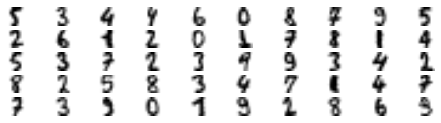

In [20]:
## Try using Clustering, 
kmeans_semi = KMeans(n_clusters=50, random_state=42)  ## assume 50 clusters
kmeans_semi.fit(X_train)  ## clustering doesn't need labels (no cutoff, but all the dataset)

## Get for each instance the distanc to each centroid
each_dist = kmeans_semi.transform(X_train)

## Get the indecies of the nearest image to each centroid (only return Images=Number of centroid) -- 50 here
idx_min = np.argmin(each_dist, axis=0)  ## Note: argmin - returns indecies
X_train_represnt = X_train[idx_min]

## Plotting
fig, ax = plt.subplots(5, 10, figsize=(8, 2))
i = 0
for row in range(5):
    for col in range(10):
        plt.sca(ax[row, col])
        plt.imshow(X_train_represnt[i].reshape(8, 8), cmap='binary', interpolation='bilinear')
        plt.axis('off')
        i+=1

In [19]:
## Labelling the above results Manually (each one represent its cluster)
y_labeled_manually = np.array([5, 3, 4, 4, 6, 0, 8, 7, 9, 5, 2, 6, 1, 2, 
                               0, 1, 7, 8, 1, 4, 5, 3, 7, 2, 3, 9, 9, 3, 4, 2, 8, 
                               2, 5, 8, 3, 4, 7, 8, 4, 7, 7, 3, 9, 0, 1, 9, 2, 8, 6, 9])

## train the model again 
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=6000, random_state=42)
log_reg.fit(X_train_represnt, y_labeled_manually)

print(f'Score after Clustering ---- {log_reg.score(X_test, y_test):.5f}')  ### beform much better the the above model

Score after Clustering ---- 0.87333


---

### `DBSCAN`

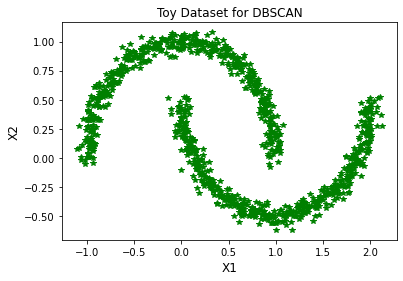

In [3]:
## Try DBSCAN
## Create dataset
X, y = datasets.make_moons(n_samples=1000, noise=0.05, random_state=42)  ## we dont't need y, only x (two features)

plt.plot(X[:,0], X[:,1], 'g*')
plt.title('Toy Dataset for DBSCAN', fontsize=12)
plt.xlabel('X1', fontsize=12)
plt.ylabel('X2', fontsize=12)
plt.show()

In [117]:
## Intilaize DBSCAN Model
dbscan_1 = DBSCAN(eps=0.09, min_samples=5)  ## take your time playing with these hyperparams
dbscan_1.fit(X)

DBSCAN(eps=0.09)

In [55]:
## Core points are valid in 
core_points = dbscan_1.components_
print('Core Points in this Dataset are --- \n', core_points)

print('**'*15)

## Indecies of core points
idx_cores = dbscan_1.core_sample_indices_
print('Number of core points in this Dataset ---', len(idx_cores))

Core Points in this Dataset are --- 
 [[-0.02137124  0.40618608]
 [ 0.97670045 -0.45832306]
 [ 0.90405882 -0.37651952]
 ...
 [ 1.66258462 -0.3079193 ]
 [-0.94355873  0.3278936 ]
 [ 0.79419406  0.60777171]]
******************************
Number of core points in this Dataset --- 980


In [71]:
## The final clusters according to the above Hyperparams
df_outs = pd.DataFrame(np.c_[X, dbscan_1.labels_], columns=['X1', 'X2', 'Clusters'])
df_outs['Clusters'].unique()   ## You have (0 & 1) clusters,  (-1) --> is for outliers (anomalies == Noise)

array([ 0.,  1., -1.])

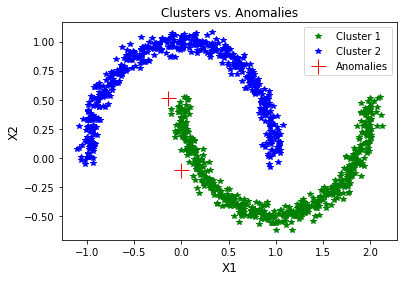

In [85]:
## Plotting the core points vs. anomalies
plt.plot(df_outs[df_outs['Clusters']==0]['X1'], df_outs[df_outs['Clusters']==0]['X2'], 'g*', label='Cluster 1')
plt.plot(df_outs[df_outs['Clusters']==1]['X1'], df_outs[df_outs['Clusters']==1]['X2'], 'b*', label='Cluster 2')
plt.plot(df_outs[df_outs['Clusters']==-1]['X1'], df_outs[df_outs['Clusters']==-1]['X2'], 'r+', markersize=15, label='Anomalies')

plt.title('Clusters vs. Anomalies', fontsize=12)
plt.xlabel('X1', fontsize=12)
plt.ylabel('X2', fontsize=12)
plt.legend()
plt.show()

### `DBSAN has no predict() method, to predict new instances you can define a classifier and go on`

In [113]:
## Run a classifier, you can pass to the Model, (X, Y) which you want
## I mean you can pass all data (cores and anomalies)
## You can pass only core points (which I will do), or you can do only anomalies data

## Using KNN
knn_dbscan = KNeighborsClassifier(n_neighbors=50)

X_for_predict = dbscan_1.components_   ## core points
y_for_predict = dbscan_1.labels_[dbscan_1.core_sample_indices_]    ## cluster number (label) for core points

knn_dbscan.fit(X_for_predict, y_for_predict)


## Inference
## predict new 
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
y_pred_new = knn_dbscan.predict(X_new)
print('Prediction --- \n', y_pred_new)

print('***'*15)

## for probability
results_prob = knn_dbscan.predict_proba(X_new)
print('Probability for each class --- \n', results_prob)

Prediction --- 
 [1 0 1 0]
*********************************************
Probability for each class --- 
 [[0.16 0.84]
 [1.   0.  ]
 [0.18 0.82]
 [1.   0.  ]]


------

### `Hierarchical Clustering`

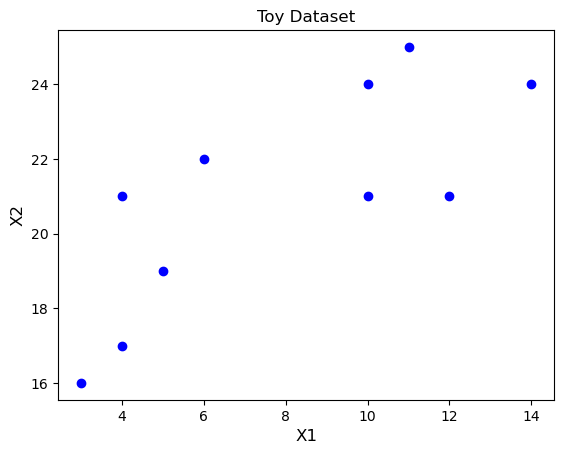

In [7]:
## Try Hierarchical Clustering ---> You can both sklearn & scipy

## To only illustrate ---> using toy dataset
X1 = np.array([4, 5, 10, 4, 3, 11, 14 , 6, 10, 12])
X2 = np.array([21, 19, 24, 17, 16, 25, 24, 22, 21, 21])

df_toy = pd.DataFrame(np.c_[X1, X2], columns=['X1', 'X2'])

## plotting
plt.plot(df_toy['X1'], df_toy['X2'], 'bo')
plt.title('Toy Dataset', fontsize=12)
plt.xlabel('X1', fontsize=12)
plt.ylabel('X2', fontsize=12)
plt.show()

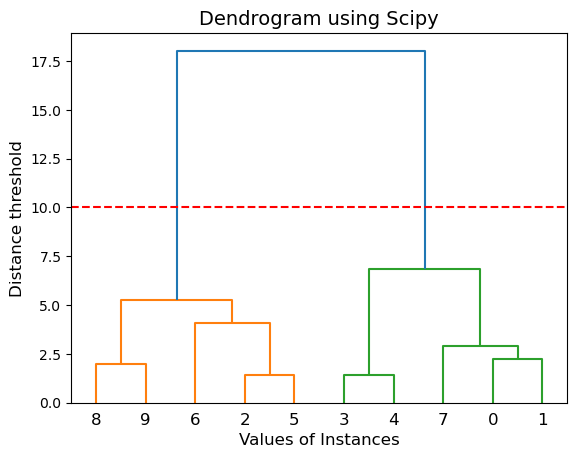

In [8]:
## Using scipy
clustered_scipy = linkage(df_toy.values, method='ward', metric='euclidean')

## for plotting
dendrogram(clustered_scipy)
plt.title('Dendrogram using Scipy', fontsize=14)
plt.xlabel('Values of Instances', fontsize=12)
plt.ylabel('Distance threshold', fontsize=12)
plt.axhline(y=10, c='r', linestyle='--')
plt.show()

In [43]:
## Using sklearn
clustered_sklearn = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
clustered_sklearn.fit(df_toy.values)

C:\Users\elwady\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean')

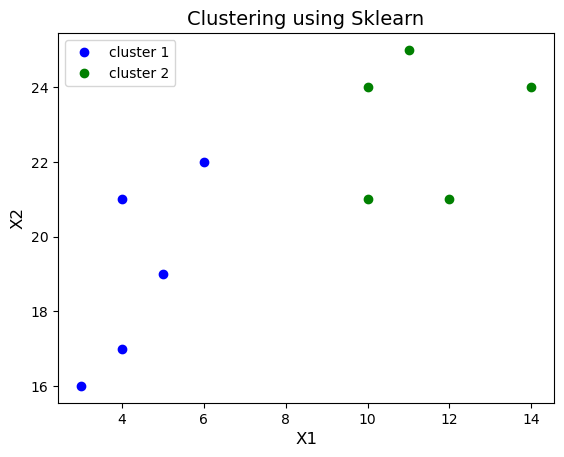

In [44]:
## Add the clustering laebel to the DF
df_toy['Labels'] = clustered_sklearn.labels_

## Plotting
plt.plot(df_toy[df_toy['Labels']==0]['X1'], df_toy[df_toy['Labels']==0]['X2'], 'bo', label='cluster 1')
plt.plot(df_toy[df_toy['Labels']==1]['X1'], df_toy[df_toy['Labels']==1]['X2'], 'go', label='cluster 2')
plt.title('Clustering using Sklearn', fontsize=14)
plt.xlabel('X1', fontsize=12)
plt.ylabel('X2', fontsize=12)
plt.legend()
plt.show()

In [25]:

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    

In [40]:
## Using sklearn
clustered_sklearn_dgram = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward', distance_threshold=0)
clustered_sklearn_dgram.fit(df_toy.values)

C:\Users\elwady\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', distance_threshold=0,
                        n_clusters=None)

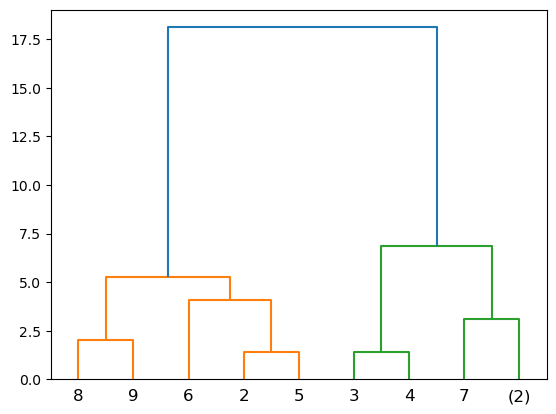

In [42]:
plot_dendrogram(clustered_sklearn_dgram, truncate_mode="level", p=2)

### `You can not use hierarchical clustering for inference, it has no .predict() function`
#### [How to predict the cluster label of a new observation using a hierarchical clustering](https://stackoverflow.com/questions/64589016/how-to-predict-the-cluster-label-of-a-new-observation-using-a-hierarchical-clust)

-----

### `Gaussian Mixture Models`

In [198]:
## Try on Toy Dataset (in slides)

## The Dataset itself
data_gmm = np.array([[10, 5], [2, 1], [3, 7]])

## Initialize random centroids, I want 3 clusters -- (each centroid has two values because the dataset has two features)
centroids_gmm = np.array([[3, 4], [6, 3], [4, 6]])

## Initialize random covariance matrix
covariance_gmm = np.array([[3, 0], [0, 3]])

## Initialize random Distribution weight -- sum of them must be 1 -- Let's make them equal each with 1/3
weights_gmm = np.array([1/3., 1/3., 1/3.])

In [199]:
print('Random Covariance Matrix -- \n', covariance_gmm)
print('Ranom Distribution weight --', weights_gmm)

Random Covariance Matrix -- 
 [[3 0]
 [0 3]]
Ranom Distribution weight -- [0.33333333 0.33333333 0.33333333]


In [224]:
## Get the responsibilities for each cluster at each observation

## Get the resposnibilty for each cluster at the first observation (instance)
resp_cluster_1 = [weights_gmm[i] * multivariate_normal.pdf(x=data_gmm[0], mean=centroids_gmm[i], cov=covariance_gmm) 
                  for i in range(3)]

## Normalizing
resp_cluster_1 = resp_cluster_1/np.sum(resp_cluster_1)


## Get the resposnibilty for each cluster at the second observation (instance)
resp_cluster_2 = [weights_gmm[i] * multivariate_normal.pdf(x=data_gmm[1], mean=centroids_gmm[i], cov=covariance_gmm) 
                  for i in range(3)]

## Normalizing
resp_cluster_2 = resp_cluster_2/np.sum(resp_cluster_2)

## Get the resposnibilty for each cluster at the third observation (instance)
resp_cluster_3 = [weights_gmm[i] * multivariate_normal.pdf(x=data_gmm[2], mean=centroids_gmm[i], cov=covariance_gmm) 
                  for i in range(3)]

## Normalizing
resp_cluster_3 = resp_cluster_3/np.sum(resp_cluster_3)

In [227]:
## The final Normalized responsibilty matrix
respon_matrix = np.row_stack((resp_cluster_1, resp_cluster_2, resp_cluster_3))
print('The Responsibilities Matrix is -- \n', respon_matrix)

The Responsibilities Matrix is -- 
 [[0.00632342 0.93847858 0.055198  ]
 [0.81233485 0.15343023 0.03423491]
 [0.23360371 0.01623159 0.7501647 ]]


In [ ]:
### for M-step, I will do it manually, check slides

----------

### `GMM on practice`

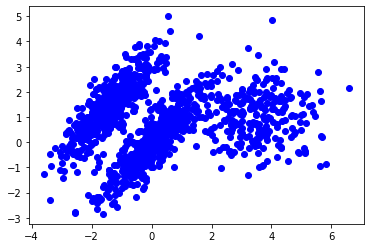

In [239]:
## Try GMM on some funcy dataset

## make some datasets --- by (aurielien geron)
X1, y1 = datasets.make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = datasets.make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

## plotting
plt.plot(X[:, 0], X[:, 1], 'bo')
plt.show()

In [242]:
## Initialize the model
## n_init ---> like k-means -- to run the model more than one time and return the best
## take care because the default is (1) not like k-means
gmm = GaussianMixture(n_components=3, n_init=10, random_state=42)  ## try 3 clusters
gmm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

In [249]:
## You have two features, and you want 3 clusters, you can check weights, mean, covariance
print('Does the Model converged ---', gmm.converged_)
print('**'*15)
print('Number of iterations till convergence ---', gmm.n_iter_)
print('**'*15)
print('Final Weights of Clusters --- ', gmm.weights_)
print('**'*20)
print('Final Means of Clusters ---', gmm.means_)
print('**'*20)
print('Final Covariance Matrices for each Cluster --- \n', gmm.covariances_)

Does the Model converged --- True
******************************
Number of iterations till convergence --- 4
******************************
Final Weights of Clusters ---  [0.39025715 0.40007391 0.20966893]
****************************************
Final Means of Clusters --- [[ 0.05131611  0.07521837]
 [-1.40763156  1.42708225]
 [ 3.39893794  1.05928897]]
****************************************
Final Covariance Matrices for each Cluster --- 
 [[[ 0.68799922  0.79606357]
  [ 0.79606357  1.21236106]]

 [[ 0.63479409  0.72970799]
  [ 0.72970799  1.1610351 ]]

 [[ 1.14833585 -0.03256179]
  [-0.03256179  0.95490931]]]


In [251]:
## You can predict and predict_proba for new instances
X_new = X[50:150]  ## Let them as new
y_pred_gmm = gmm.predict(X_new)
y_pred_proba_gmm = gmm.predict_proba(X_new)

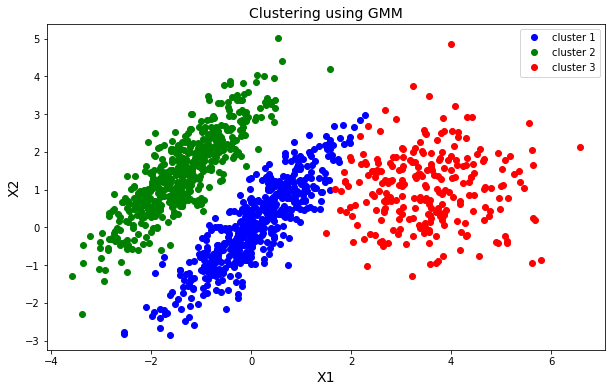

In [259]:
## Plotting
y_pred_all = gmm.predict(X)

plt.figure(figsize=(10, 6))
plt.plot(X[y_pred_all==0][:, 0], X[y_pred_all==0][:, 1], 'bo', label='cluster 1')
plt.plot(X[y_pred_all==1][:, 0], X[y_pred_all==1][:, 1], 'go', label='cluster 2')
plt.plot(X[y_pred_all==2][:, 0], X[y_pred_all==2][:, 1], 'ro', label='cluster 3')
plt.legend()
plt.title('Clustering using GMM', fontsize=14, c='k')
plt.xlabel('X1', fontsize=14, c='k')
plt.ylabel('X2', fontsize=14, c='k')
plt.show()

-----

## `Done`